In [35]:
import jsonlines
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import json
from tqdm import tqdm
import colorcet as cc
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from prettytable import PrettyTable

import statsmodels.formula.api as smf

#### Loading data 

In [36]:
climate_videos_path = "data/climate_videos_v3.jsonl"
all_sample_videos_path = "data/sampled_dataset_1percent.jsonl"
#feather_path = "data/yt_metadata_helper.feather"
nb_videos_by_cat_path = "data/nb_videos_by_cat.jsonl"


In [37]:
#video_dataset_feather = pd.read_feather(feather_path)

In [38]:
#For statistics on the entire dataset, we use the sampled dataset which will not give exact results but will be statistically relevent
all_videos_df = pd.read_json(all_sample_videos_path, lines=True)
#all_videos_df = pd.read_feather(feather_path)

In [39]:
#all_videos_df['upload_date'] = all_videos_df['upload_date'].dt.strftime('%Y-%m-%d')

In [40]:
climate_videos_df = pd.read_json(climate_videos_path, lines=True)

#### What are the categories of Climate Related videos compared to overall youtube? 

In [41]:
climate_videos_df['categories'] = climate_videos_df['categories'].replace('', 'not specified')

In [42]:
#Coutning the number of videos in each category
category_counts_climate = climate_videos_df['categories'].value_counts()
category_counts_all = nb_videos_by_cat = pd.read_json(nb_videos_by_cat_path, lines=True)
category_counts_all['categories'] = category_counts_all['categories'].replace('', 'not specified')
category_counts_all = category_counts_all.set_index('categories').squeeze()
categories = category_counts_climate.index

fig = px.pie(category_counts_climate.reset_index(),
             values='count',
             names='categories',
             title='Categories Distribution - Climate Change related Videos',
             width=800,
             height=800,
             category_orders={"categories":categories.to_list()[::-1]})
fig.update_layout(showlegend=False)
fig.update_traces( textinfo='percent+label', textposition='inside')

fig.show()

fig = px.pie(category_counts_all.reset_index(),
             values='count',
             names='categories',
             title='Categories Distribution - All Videos',
             width=800,
             height=800,
             category_orders={"categories":categories.to_list()[::-1]})
fig.update_traces(textinfo='percent+label', textposition='inside')
fig.update_layout(showlegend=False)
fig.show()


In [43]:
climate_videos_df['quarter'] = pd.to_datetime(climate_videos_df['upload_date']).dt.to_period('Q')

evolution_category_counts_climate = (climate_videos_df[['categories', 'quarter', 'display_id']].groupby(
                                                                    ['categories', 'quarter']).aggregate(
                                                                    'count')).unstack(
                                                                    fill_value=0).stack().reset_index() #add 0 values when there is no video in a category for a given time


evolution_category_counts_climate = evolution_category_counts_climate.rename(columns={'display_id': 'count'})
evolution_category_counts_climate['quarter'] = evolution_category_counts_climate['quarter'].astype(str)

fig = px.area(evolution_category_counts_climate.reset_index(), x="quarter", y="count", color="categories", category_orders={"categories":categories.to_list()[::-1]})
fig.show()

total_counts = evolution_category_counts_climate.groupby('quarter')['count'].sum() #number of videos added per time unit
evolution_category_counts_climate['proportion'] = evolution_category_counts_climate.apply(lambda row: row['count']/total_counts[row['quarter']], axis=1)

fig = px.area(evolution_category_counts_climate.reset_index(), x="quarter", y="proportion", color="categories", category_orders={"categories":categories.to_list()[::-1]})
fig.show()

Based on this category analysis we choose some relevent categories (thos with more than 1000 videos related to climate change)

In [44]:
relevent_cat = category_counts_climate[category_counts_climate > 1000].reset_index()
relevent_cat = relevent_cat.drop(columns = ['count'])

One hot encoding if a video is climate change related in all_videos dataset

In [64]:
columns = ['categories', 'month', 'view_count', 'display_id', 'like_count', 'dislike_count']

obs_study_climate_videos_df = climate_videos_df.dropna(subset=['view_count', 'like_count', 'dislike_count'])
obs_study_climate_videos_df = obs_study_climate_videos_df[(obs_study_climate_videos_df['view_count'] > 0) &
                                                          (obs_study_climate_videos_df['like_count'] <= obs_study_climate_videos_df['view_count']) &
                                                          (obs_study_climate_videos_df['dislike_count'] <= obs_study_climate_videos_df['view_count'])]

obs_study_climate_videos_df['month'] = pd.to_datetime(obs_study_climate_videos_df['upload_date']).dt.to_period('M')
obs_study_climate_videos_df['is_climate'] = 1

all_videos_df['categories'] = all_videos_df['categories'].replace('', 'not specified')

obs_study_all_videos_df = all_videos_df.dropna(subset=['view_count', 'like_count', 'dislike_count'])
obs_study_all_videos_df = obs_study_all_videos_df[(obs_study_all_videos_df['view_count'] > 0) &
                                                (obs_study_all_videos_df['like_count'] <= obs_study_all_videos_df['view_count']) &
                                                (obs_study_all_videos_df['dislike_count'] <= obs_study_all_videos_df['view_count'])]

obs_study_all_videos_df['month'] = pd.to_datetime(obs_study_all_videos_df['upload_date']).dt.to_period('M')


obs_study_all_videos_df = obs_study_all_videos_df.merge(obs_study_climate_videos_df,how='left', on=obs_study_all_videos_df.columns.to_list())
obs_study_all_videos_df['is_climate'] = obs_study_all_videos_df['is_climate'].fillna(0)

obs_study_non_climate_videos_df = obs_study_all_videos_df[obs_study_all_videos_df['is_climate'] == 0]

columns = columns + ['is_climate']

obs_study_climate_videos_df = obs_study_climate_videos_df[columns]
obs_study_non_climate_videos_df = obs_study_all_videos_df[columns]


### Different view counts ?

In [65]:
matching_df = obs_study_climate_videos_df.merge(right = obs_study_non_climate_videos_df,
                                                on = ['categories', 'month'],
                                                suffixes=('_climate', '_non_climate'))

matching_df = matching_df.groupby(['categories','display_id_climate', 'view_count_climate', 'is_climate_climate']).agg({
    'view_count_non_climate' : 'mean' ,
    'display_id_non_climate' : (lambda x : ",".join(x)),
    'is_climate_non_climate' : (lambda x : 0)
}
).reset_index()

matching_df = matching_df.reset_index()


In [66]:
climate_matched = matching_df[['categories','display_id_climate', 'view_count_climate', 'is_climate_climate']]
cols = ['categories','display_id', 'view_count', 'is_climate']

climate_matched = climate_matched.rename(columns = {old : new for old,new in zip(climate_matched.columns, cols)})

non_climate_matched = matching_df[['categories','display_id_non_climate', 'view_count_non_climate', 'is_climate_non_climate']]
non_climate_matched = non_climate_matched.rename(columns = {old : new for old,new in zip(non_climate_matched.columns, cols)})


obs_study_df = pd.concat([climate_matched,non_climate_matched])

In [67]:
display(obs_study_df)

,categories,display_id,view_count,is_climate
0,Autos & Vehicles,-YfH4P6XGqw,137.000000,1
1,Autos & Vehicles,-mNrHcFEohA,55617.000000,1
2,Autos & Vehicles,-uWKnfQJHDU,5028.000000,1
3,Autos & Vehicles,04CMY-SLjFE,7447.000000,1
4,Autos & Vehicles,08gUMhj64NE,1126.000000,1
...,...,...,...,...
67286,Travel & Events,"7MKHw0uf-T4,1s363J4MJ8Y,ZRIXfghsRTo,7q9W7D-LtM...",20801.085106,0
67287,Travel & Events,"WNmfpoaZr54,FPVgOJdaGfE,sHEoMxsfvuk,6uHOieYpqX...",8640.950000,0
67288,Travel & Events,"515EKAmSPX0,J3xXys3n3xc,W2mR8RyoisY,RClW1yUNdV...",70707.193548,0
67289,Travel & Events,"X6vIEvieCuk,GkmfeIKtLrk,nSPLnajUNhA,jgkioA5IKv...",238809.724138,0


                            OLS Regression Results                            
Dep. Variable:             view_count   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     122.0
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           2.39e-28
Time:                        21:06:14   Log-Likelihood:            -8.4462e+05
No. Observations:               67314   AIC:                         1.689e+06
Df Residuals:                   67312   BIC:                         1.689e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.945e+04    371.107     52.410      0.0

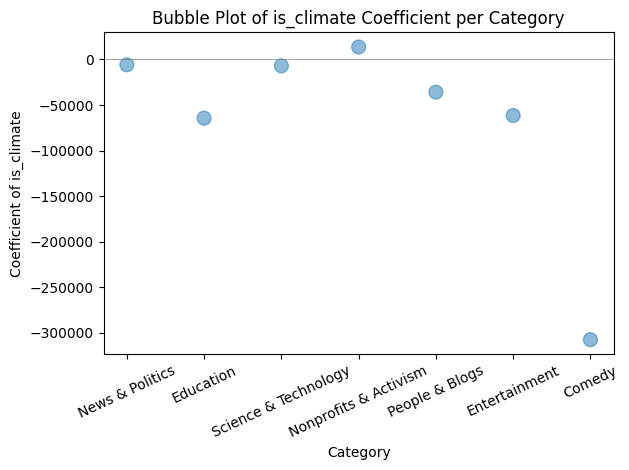

In [80]:
categories = []
intercepts = []
coefficients = []
intercept_pvals = []
coefficient_pvals = []
coef_colors = []

for category in relevent_cat['categories']:
    # Fit the model for each category
    model = smf.ols(formula='view_count ~ is_climate', data=obs_study_df[obs_study_df['categories'] == category])
    result = model.fit()
    
    print(result.summary())

    # Retrieve the intercept and coefficient
    intercept, coef = result.params
    
    # Check p-values for statistical relevance
    intercept_p, coef_p = result.pvalues
    
    # Determine if values are statistically relevant
    intercept_val = "Not statistically relevant" if intercept_p >= 0.05 else intercept
    coef_val = "Not statistically relevant" if coef_p >= 0.05 else coef
    
    # Store the results and color
    categories.append(category)
    intercepts.append(intercept)
    coefficients.append(coef)
    intercept_pvals.append(intercept_p)
    coefficient_pvals.append(coef_p)

print(coefficient_pvals)

sizes = [100 for _ in range(len(categories))] # Replace with actual values representing the size of each bubble

# Create the bubble plot
plt.scatter(categories, coefficients, s = sizes ,alpha=0.5)  # 's' determines the size of each bubble

# Customize the plot
plt.title('Bubble Plot of is_climate Coefficient per Category')
plt.xlabel('Category')
plt.ylabel('Coefficient of is_climate')
plt.axhline(0, color='grey', lw=0.5)  # Add a line at y=0 for reference
plt.xticks(rotation=25)  # Rotate category names for better readability

# Optional: Add a color scale or other features to represent additional dimensions

# Show the plot
plt.tight_layout()  # Adjust the layout for a better fit
plt.show()

Observations: 
- Different predominant categories, as expected
- Main for climate change: N&P, Education, Science & Tech 

**We study like/dislikes comparison metrics**


$$SLDR(N_{like}, N_{dislike}) =  (-1)^{\delta} \dfrac{\max{(N_{like} , N_{dislike}) + 1}}{\min{(N_{like} , N_{dislike} ) +1 } }$$

### Matching

In [49]:
test_grouped = obs_study_climate_videos_df.groupby('view_count')

In [50]:
obs_study_climate_videos_df = obs_study_climate_videos_df.sort_values('view_count')
obs_study_climate_videos_df['view_count'] = obs_study_climate_videos_df['view_count'].astype(int)
obs_study_climate_videos_df['view_count_climate'] = obs_study_climate_videos_df['view_count']

obs_study_non_climate_videos_df = obs_study_non_climate_videos_df.sort_values('view_count')
obs_study_non_climate_videos_df['view_count'] = obs_study_non_climate_videos_df['view_count'].astype(int)
obs_study_non_climate_videos_df['view_count_non_climate'] = obs_study_non_climate_videos_df['view_count']

not_matched_climate_videos_df = obs_study_climate_videos_df #climate videos who were not matched (all of them for now)
not_matched_non_climate_videos_df = obs_study_non_climate_videos_df #non climate videos who were not matched (all of them for now)

matching_df = pd.DataFrame()

print(not_matched_climate_videos_df.shape[0])

while not_matched_climate_videos_df.shape[0] > 0: #purpose is to matched as many climate videos as possible

    not_matched_climate_videos_df = not_matched_climate_videos_df.sort_values('view_count') #sorting to be able to use merge_asof
    not_matched_non_climate_videos_df = not_matched_non_climate_videos_df.sort_values('view_count')


    matching_2_df = pd.merge_asof(
                                left = not_matched_climate_videos_df,
                                right = not_matched_non_climate_videos_df, 
                                on='view_count', #nearest match on view count
                                by=['categories', 'month'], #exact match on categories and month
                                suffixes=('_climate', '_non_climate'), direction = 'nearest')
    
    matching_2_df['relative_diff'] = (matching_2_df['view_count_climate'] - matching_2_df['view_count_non_climate']).abs()/matching_2_df[['view_count_non_climate', 'view_count_climate']].max(axis=1)
                                            #view_count relative differences in the match we found
    
    #allowing only matches with samll enough view count relative_diff
    matching_2_df = matching_2_df.sort_values('relative_diff')
    matching_2_df = matching_2_df[matching_2_df['relative_diff'] < 0.1]

    #Since several_climate_videos may have been matched with a single non_climate_videos, we only keep the best match for each duplicates 
    matching_2_df_filtered = matching_2_df.drop_duplicates(subset = 'display_id_non_climate', keep ='first')

    #not matched dfs are updated: climate_videos who were droped when we droped the duplicates above.
    not_matched_climate_videos_df = not_matched_climate_videos_df[~not_matched_climate_videos_df['display_id'].isin(matching_2_df_filtered['display_id_climate'])
                                                            & not_matched_climate_videos_df['display_id'].isin(matching_2_df['display_id_climate'])]
    #non_climate_videos who were not yet used for a match
    not_matched_non_climate_videos_df = not_matched_non_climate_videos_df[~not_matched_non_climate_videos_df['display_id'].isin(matching_2_df['display_id_non_climate'])]
    
    print(not_matched_climate_videos_df.shape[0])

    #updating the matching
    matching_df = pd.concat([matching_df, matching_2_df_filtered])

climate_ids = matching_df['display_id_climate']
non_climate_ids = matching_df['display_id_non_climate']
matching_df = matching_df.drop(columns= ['view_count', 'relative_diff'])

67303
15397
4018
1238
442
205
104
47
26
15
9
7
5
1
0


In [51]:
display(matching_df)

,categories,month,display_id_climate,like_count_climate,dislike_count_climate,is_climate_climate,view_count_climate,display_id_non_climate,like_count_non_climate,dislike_count_non_climate,is_climate_non_climate,view_count_non_climate
33645,News & Politics,2019-03,k5WTtpXURg8,27.0,4.0,1,991,0BS4KQIgAWE,13.0,0.0,0.0,991.0
10011,News & Politics,2017-10,CTmTakKqwp4,5.0,0.0,1,120,C-xp6LOBcQU,0.0,0.0,0.0,120.0
20851,News & Politics,2016-11,DKr7ER9ADNA,2.0,4.0,1,353,YCPURlhzojc,7.0,1.0,0.0,353.0
10013,News & Politics,2019-05,rEAdyUmNz-U,2.0,3.0,1,120,3WxY7IzSbVo,0.0,0.0,0.0,120.0
53065,News & Politics,2018-04,D-UTOT_m2XY,242.0,8.0,1,6868,JfCHP1V73c8,62.0,44.0,0.0,6868.0
...,...,...,...,...,...,...,...,...,...,...,...,...
0,News & Politics,2019-09,9nGZYSU72DA,7.0,0.0,1,261,S0JeH3X4GtI,4.0,0.0,0.0,245.0
5,News & Politics,2019-09,DMHCPrRM58I,25.0,0.0,1,500,mfIq_jg_bJQ,6.0,1.0,0.0,545.0
0,News & Politics,2019-09,giWYLSlITIk,3.0,1.0,1,263,T96eMO_0Uwk,3.0,0.0,0.0,245.0
4,News & Politics,2019-09,7B7sQukx388,27.0,11.0,1,500,RS3G7EKdfOM,8.0,1.0,0.0,550.0


In [52]:
climate_cols = [name for name in matching_df.columns if 'non_climate' not in name]
non_climate_cols = ['categories','month'] +  [name for name in matching_df.columns if 'non_climate'  in name]

climate_matched = matching_df[climate_cols]
climate_matched = climate_matched.rename(columns = {old : new for old,new in zip(sorted(climate_matched.columns), sorted(columns))})

non_climate_matched = matching_df[non_climate_cols]
non_climate_matched = non_climate_matched.rename(columns = {old : new for old,new in zip(sorted(non_climate_matched.columns), sorted(columns))})

obs_study_df = pd.concat([climate_matched,non_climate_matched])

In [53]:

def sldr(like_count, dislike_count):
    mask = (like_count == 0) & (dislike_count == 0)
    result = np.where(
        mask,
        1,
        np.where(
            like_count > dislike_count,
            (like_count + 1) / (dislike_count + 1),
            - (dislike_count + 1) / (like_count + 1)
        )
    )
    return result
      

In [54]:
obs_study_df['like_prop'] = obs_study_df['like_count']/obs_study_df['view_count'] * 100
obs_study_df['dislike_prop'] = obs_study_df['dislike_count']/obs_study_df['view_count'] * 100
obs_study_df['engagement_rate'] = obs_study_df['like_prop'] + obs_study_df['dislike_prop']
obs_study_df['sldr'] = sldr(obs_study_df['like_count'], obs_study_df['dislike_count']) 
obs_study_df['dislike_to_like'] = np.where(
                    (obs_study_df['like_count'] == 0) & (obs_study_df['dislike_count'] == 0),
                    0.5,
                    obs_study_df['dislike_count']/(obs_study_df['like_count'] + obs_study_df['dislike_count'])) * 100

In [55]:
display(obs_study_df.sort_values('like_prop'))

,categories,month,display_id,like_count,dislike_count,is_climate,view_count,like_prop,dislike_prop,engagement_rate,sldr,dislike_to_like
1582,News & Politics,2017-11,UL5DLVQvcHQ,0.0,2.0,1.0,69.0,0.000000,2.898551,2.898551,-3.0,100.0
32031,News & Politics,2019-06,eHkIOY2d_T4,0.0,2.0,0.0,871.0,0.000000,0.229621,0.229621,-3.0,100.0
34492,Education,2010-04,mptq9HEWX64,0.0,0.0,0.0,1097.0,0.000000,0.000000,0.000000,1.0,50.0
1774,News & Politics,2017-12,_Q0mDo31e4c,0.0,0.0,0.0,79.0,0.000000,0.000000,0.000000,1.0,50.0
8744,Nonprofits & Activism,2016-07,cEZtQ1dytk0,0.0,0.0,0.0,100.0,0.000000,0.000000,0.000000,1.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2109,Comedy,2016-12,WolqlOTe5xo,13.0,0.0,0.0,24.0,54.166667,0.000000,54.166667,14.0,0.0
14847,People & Blogs,2018-01,-yIwmpy3_Tg,121.0,0.0,1.0,209.0,57.894737,0.000000,57.894737,122.0,0.0
6001,People & Blogs,2017-06,F2jqhltV9-g,39.0,0.0,0.0,65.0,60.000000,0.000000,60.000000,40.0,0.0
10918,Education,2018-04,S2c7PUOx8KA,93.0,0.0,1.0,135.0,68.888889,0.000000,68.888889,94.0,0.0






News & Politics


                            OLS Regression Results                            
Dep. Variable:        dislike_to_like   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1774
Date:                Thu, 21 Dec 2023   Prob (F-statistic):              0.674
Time:                        19:41:53   Log-Likelihood:            -2.8543e+05
No. Observations:               62810   AIC:                         5.709e+05
Df Residuals:                   62808   BIC:                         5.709e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.6173      0.1

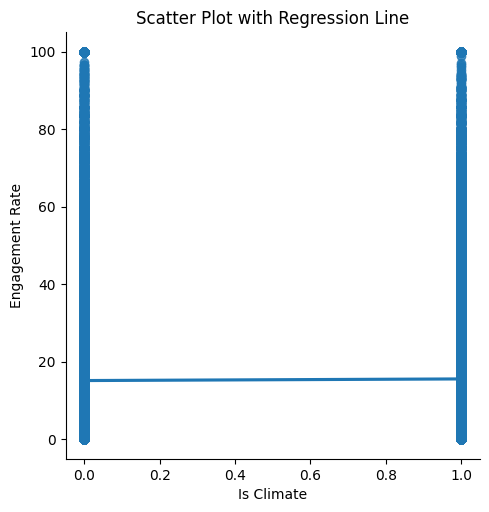





Education


                            OLS Regression Results                            
Dep. Variable:        dislike_to_like   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     17.35
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           3.14e-05
Time:                        19:41:54   Log-Likelihood:                -57925.
No. Observations:               13666   AIC:                         1.159e+05
Df Residuals:                   13664   BIC:                         1.159e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0234      0.204    

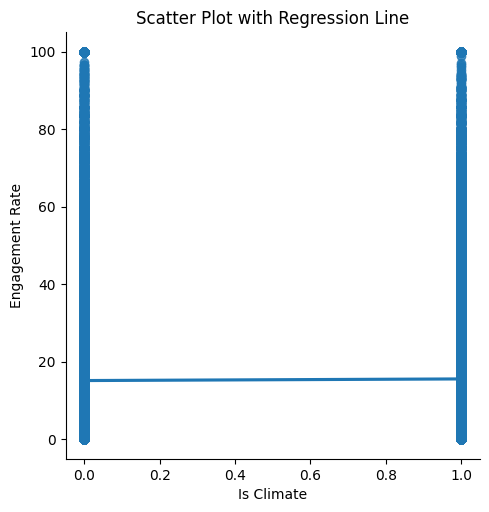





Science & Technology


                            OLS Regression Results                            
Dep. Variable:        dislike_to_like   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     55.29
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           1.11e-13
Time:                        19:41:54   Log-Likelihood:                -52225.
No. Observations:               12388   AIC:                         1.045e+05
Df Residuals:                   12386   BIC:                         1.045e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1173    

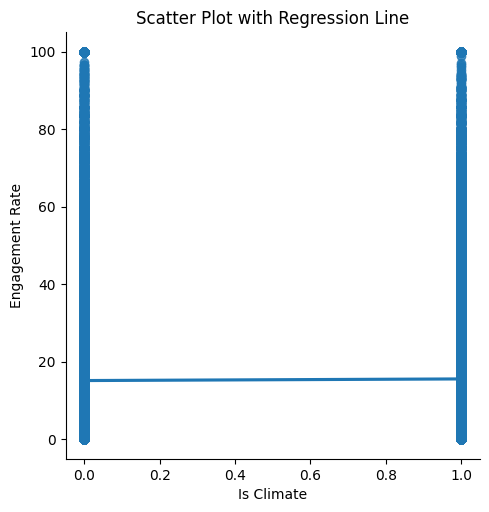





Nonprofits & Activism


                            OLS Regression Results                            
Dep. Variable:        dislike_to_like   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     15.63
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           7.77e-05
Time:                        19:41:55   Log-Likelihood:                -30262.
No. Observations:                7206   AIC:                         6.053e+04
Df Residuals:                    7204   BIC:                         6.054e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.5588   

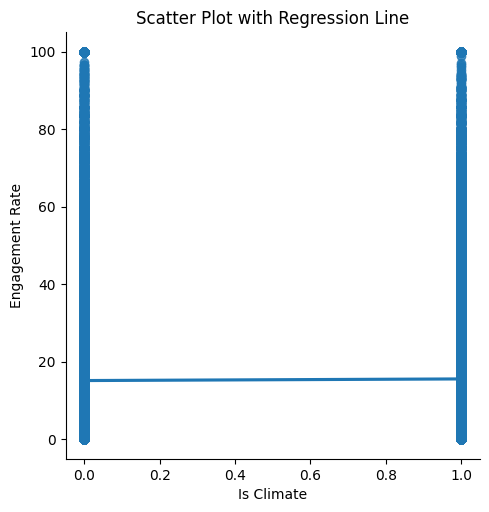





People & Blogs


                            OLS Regression Results                            
Dep. Variable:        dislike_to_like   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     38.18
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           6.81e-10
Time:                        19:41:55   Log-Likelihood:                -32868.
No. Observations:                7458   AIC:                         6.574e+04
Df Residuals:                    7456   BIC:                         6.575e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.4250      0.32

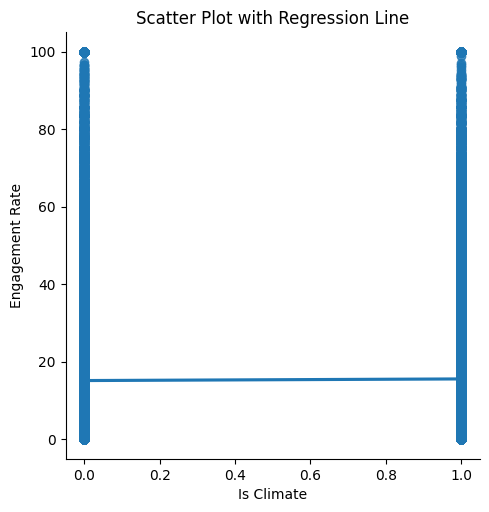





Entertainment


                            OLS Regression Results                            
Dep. Variable:        dislike_to_like   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.664
Date:                Thu, 21 Dec 2023   Prob (F-statistic):              0.103
Time:                        19:41:56   Log-Likelihood:                -23914.
No. Observations:                5474   AIC:                         4.783e+04
Df Residuals:                    5472   BIC:                         4.785e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6502      0.367

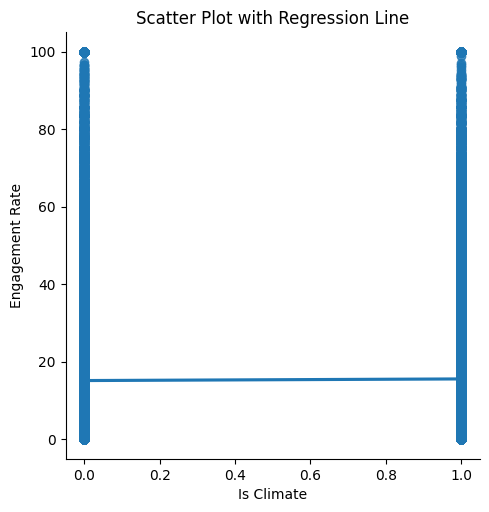





Comedy


                            OLS Regression Results                            
Dep. Variable:        dislike_to_like   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     26.04
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           3.75e-07
Time:                        19:41:56   Log-Likelihood:                -7444.9
No. Observations:                1582   AIC:                         1.489e+04
Df Residuals:                    1580   BIC:                         1.490e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.0139      0.963     19

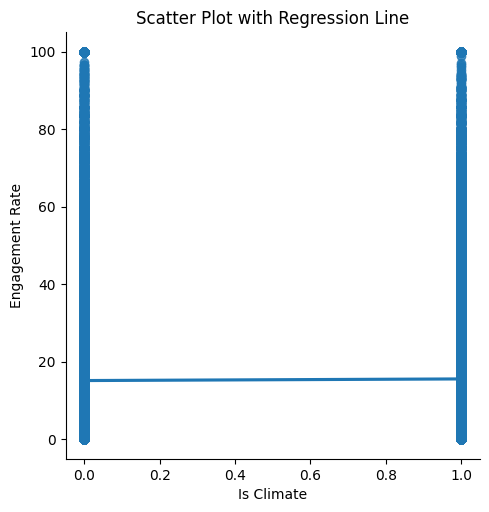

In [56]:
for categorie in relevent_cat['categories']:
    print("\n\n\n")
    print(categorie)
    print("\n")    
    model=smf.ols(formula='dislike_to_like ~ is_climate',data=obs_study_df[obs_study_df['categories'] == categorie])
    result=model.fit()

    print(result.summary())

    # Scatter plot with regression line
    sns.lmplot(x='is_climate', y='dislike_to_like', data=obs_study_df, ci=None)
    plt.title('Scatter Plot with Regression Line')
    plt.xlabel('Is Climate')
    plt.ylabel('Engagement Rate')
    plt.show()

KeyError: 'sldr'

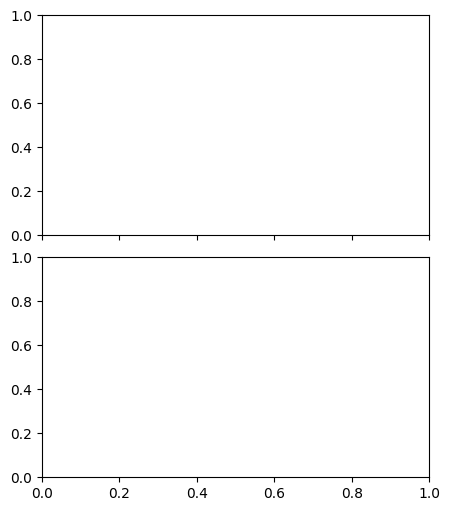

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 6))
fig.subplots_adjust(hspace=0.1)  # adjust space between axes

# plot the same data on both axes
ax1.boxplot([climate_videos_df['sldr'].dropna(), video_dataset_feather['sldr'].dropna()], showfliers=False)
ax2.boxplot([climate_videos_df['sldr'].dropna(), video_dataset_feather['sldr'].dropna()], showfliers=False)

# zoom-in / limit the view to different portions of the data
ax1.set_title('SLDR Distribution')
ax1.set_ylim(1, 70)  # outliers only
y_ticks_high = list(range(1, 70, 10))
y_ticks_high.append(1)
ax1.set_yticks(y_ticks_high)  # Set y-axis ticks

ax2.set_ylim(-40, -1)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
y_ticks_low  = list(range(-40, 0, 10))
y_ticks_low.append(-1)
ax2.set_yticks(y_ticks_low)
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
#ax1.text(1, climate_mean, f"Mean: {climate_mean:.2f}", ha='center', va='bottom', color='red')
#ax1.text(2, all_mean, f"Mean: {all_mean:.2f}", ha='center', va='bottom', color='red')

ax1.set_xticklabels(['','','Climate Videos', 'All Videos'])

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = 0  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)






In [ ]:
# Convert 'SLDR' column to numeric type
climate_sldr_plot = pd.to_numeric(climate_videos_df['sldr'].dropna())
all_sldr_plot = pd.to_numeric(all_videos_df['sldr'].dropna())

# Create a violin plot
plt.figure(figsize=(8, 6))

sns.boxplot(
    data=[climate_sldr_plot, all_sldr_plot],
    palette="Set3",
    showfliers=False
)
plt.ylim(-40, 85)
plt.title('Comparison of SLDR between Climate Videos and All Videos')
plt.xticks([0, 1], ['Climate Videos', 'All Videos'])
plt.ylabel('SLDR')
plt.show()


KeyError: 'sldr'

We can see that the like ratio is lower for climate videos. Hence they are more dabatable. And it goes much lower...

Let's now study by categories

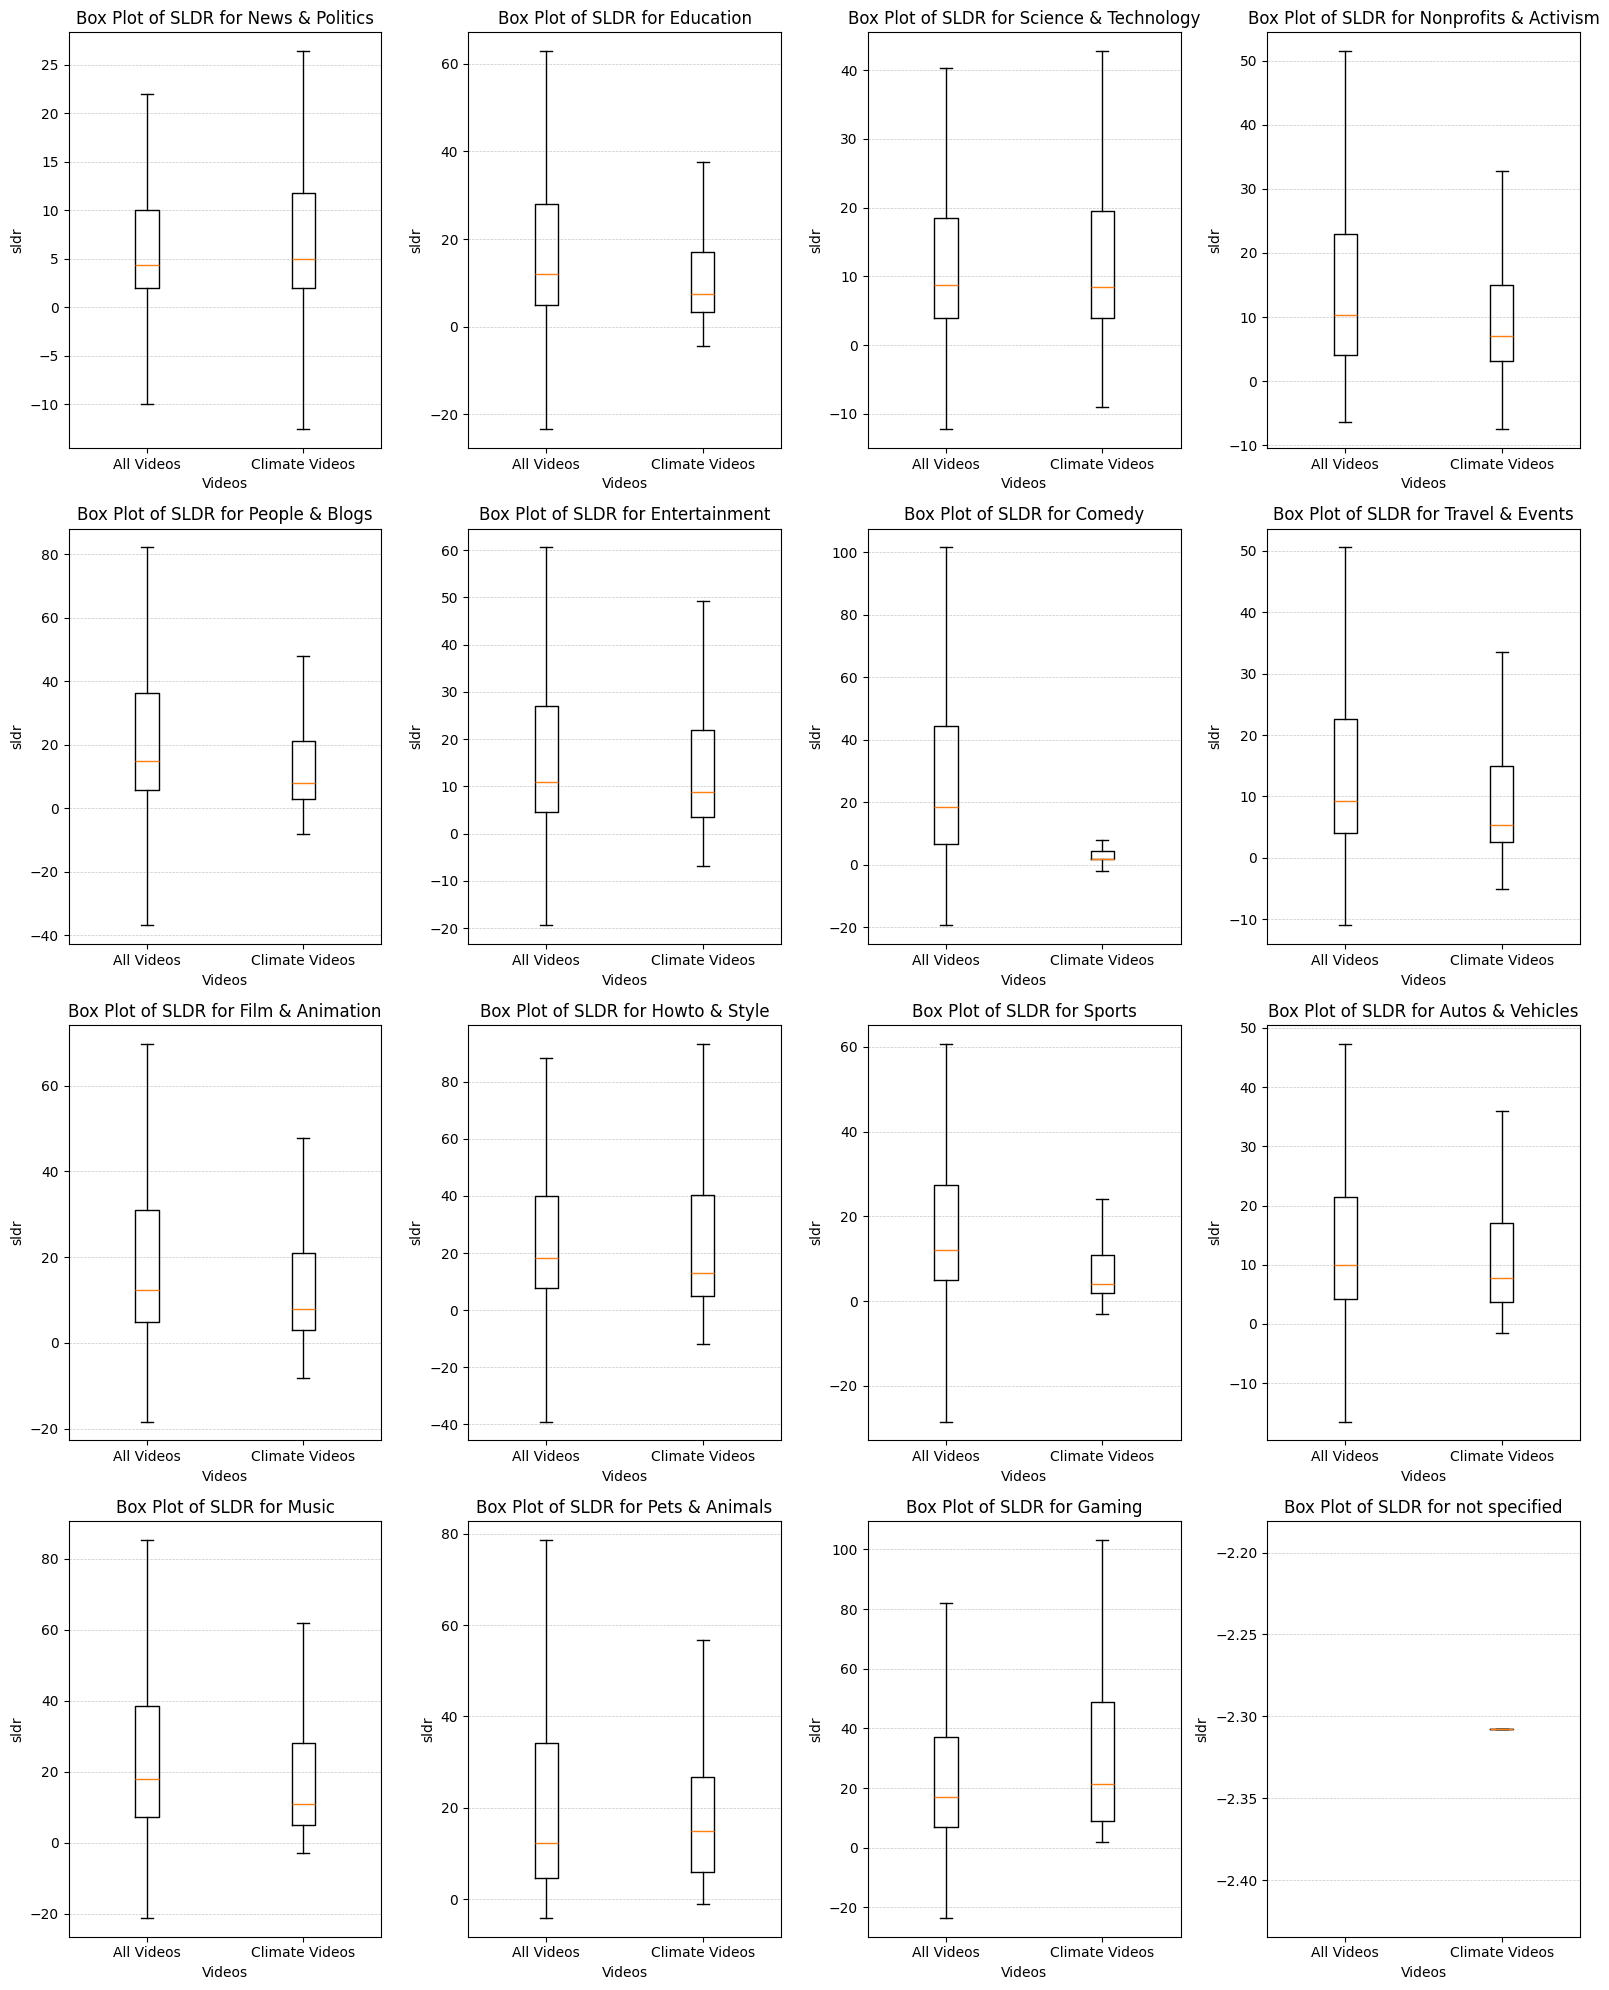

In [ ]:
plt.figure(figsize=(16, 20))  # Adjust the figure size as desired

num_categories = len(categories)
num_columns = num_categories // 4  # Number of columns in the subplot grid
num_rows = num_categories // 4   # Number of rows in the subplot grid

for i, category in enumerate(categories):
    plt.subplot(num_rows, num_columns, i+1)
    
    ndlis_all = all_videos_df.query(f"categories == '{category}'")['sldr'].dropna()
    ndlis_climate = climate_videos_df.query(f"categories == '{category}'")['sldr'].dropna()
    
    plt.boxplot([ndlis_all, ndlis_climate], showfliers=False)
    
    plt.xlabel('Videos')
    plt.ylabel('sldr')
    plt.title(f'Box Plot of SLDR for {category}')
    
    plt.grid(axis='y', which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Add x labels
    plt.xticks([1, 2], ['All Videos', 'Climate Videos'])

plt.tight_layout()
plt.show()

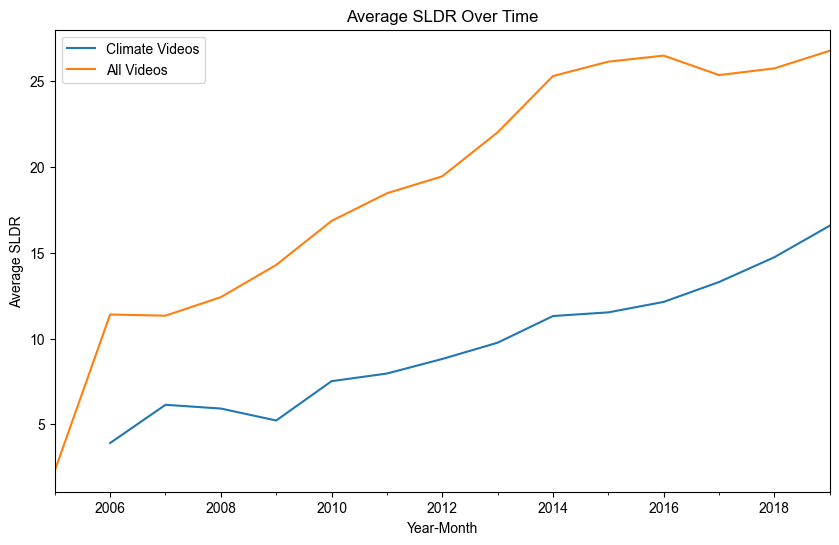

In [ ]:
for df in [climate_videos_df, all_videos_df]:
    df['upload_date'] = pd.to_datetime(df['upload_date'])
    df['year_month'] = df['upload_date'].dt.to_period('Y')
    average_like_ratio = df.groupby('year_month')['sldr'].mean()
    average_like_ratio.plot(kind='line', figsize=(10, 6))

plt.xlabel('Year-Month')
plt.ylabel('Average SLDR')
plt.title('Average SLDR Over Time')

# Add legend
plt.legend(['Climate Videos', 'All Videos'])

plt.show()


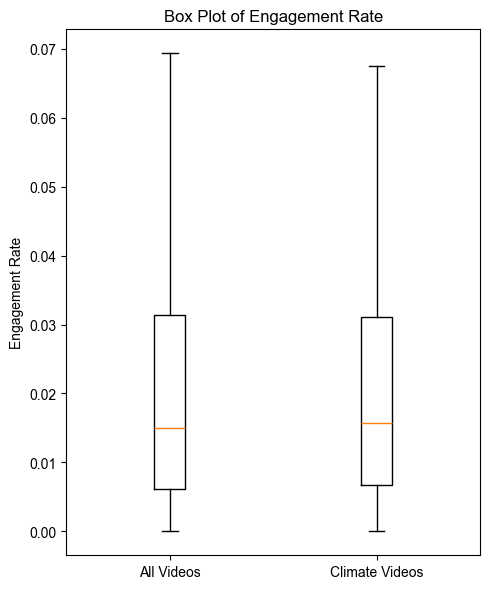

In [ ]:
plt.figure(figsize=(5, 6))
plt.boxplot([all_videos_df['engagement_rate'].dropna(),climate_videos_df['engagement_rate'].dropna()], showfliers=False)
plt.ylabel('Engagement Rate')
plt.title('Box Plot of Engagement Rate') 
#plt.grid(axis='y', which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
# Add x labels
plt.xticks([1, 2], ['All Videos', 'Climate Videos'])
plt.tight_layout()
plt.show()

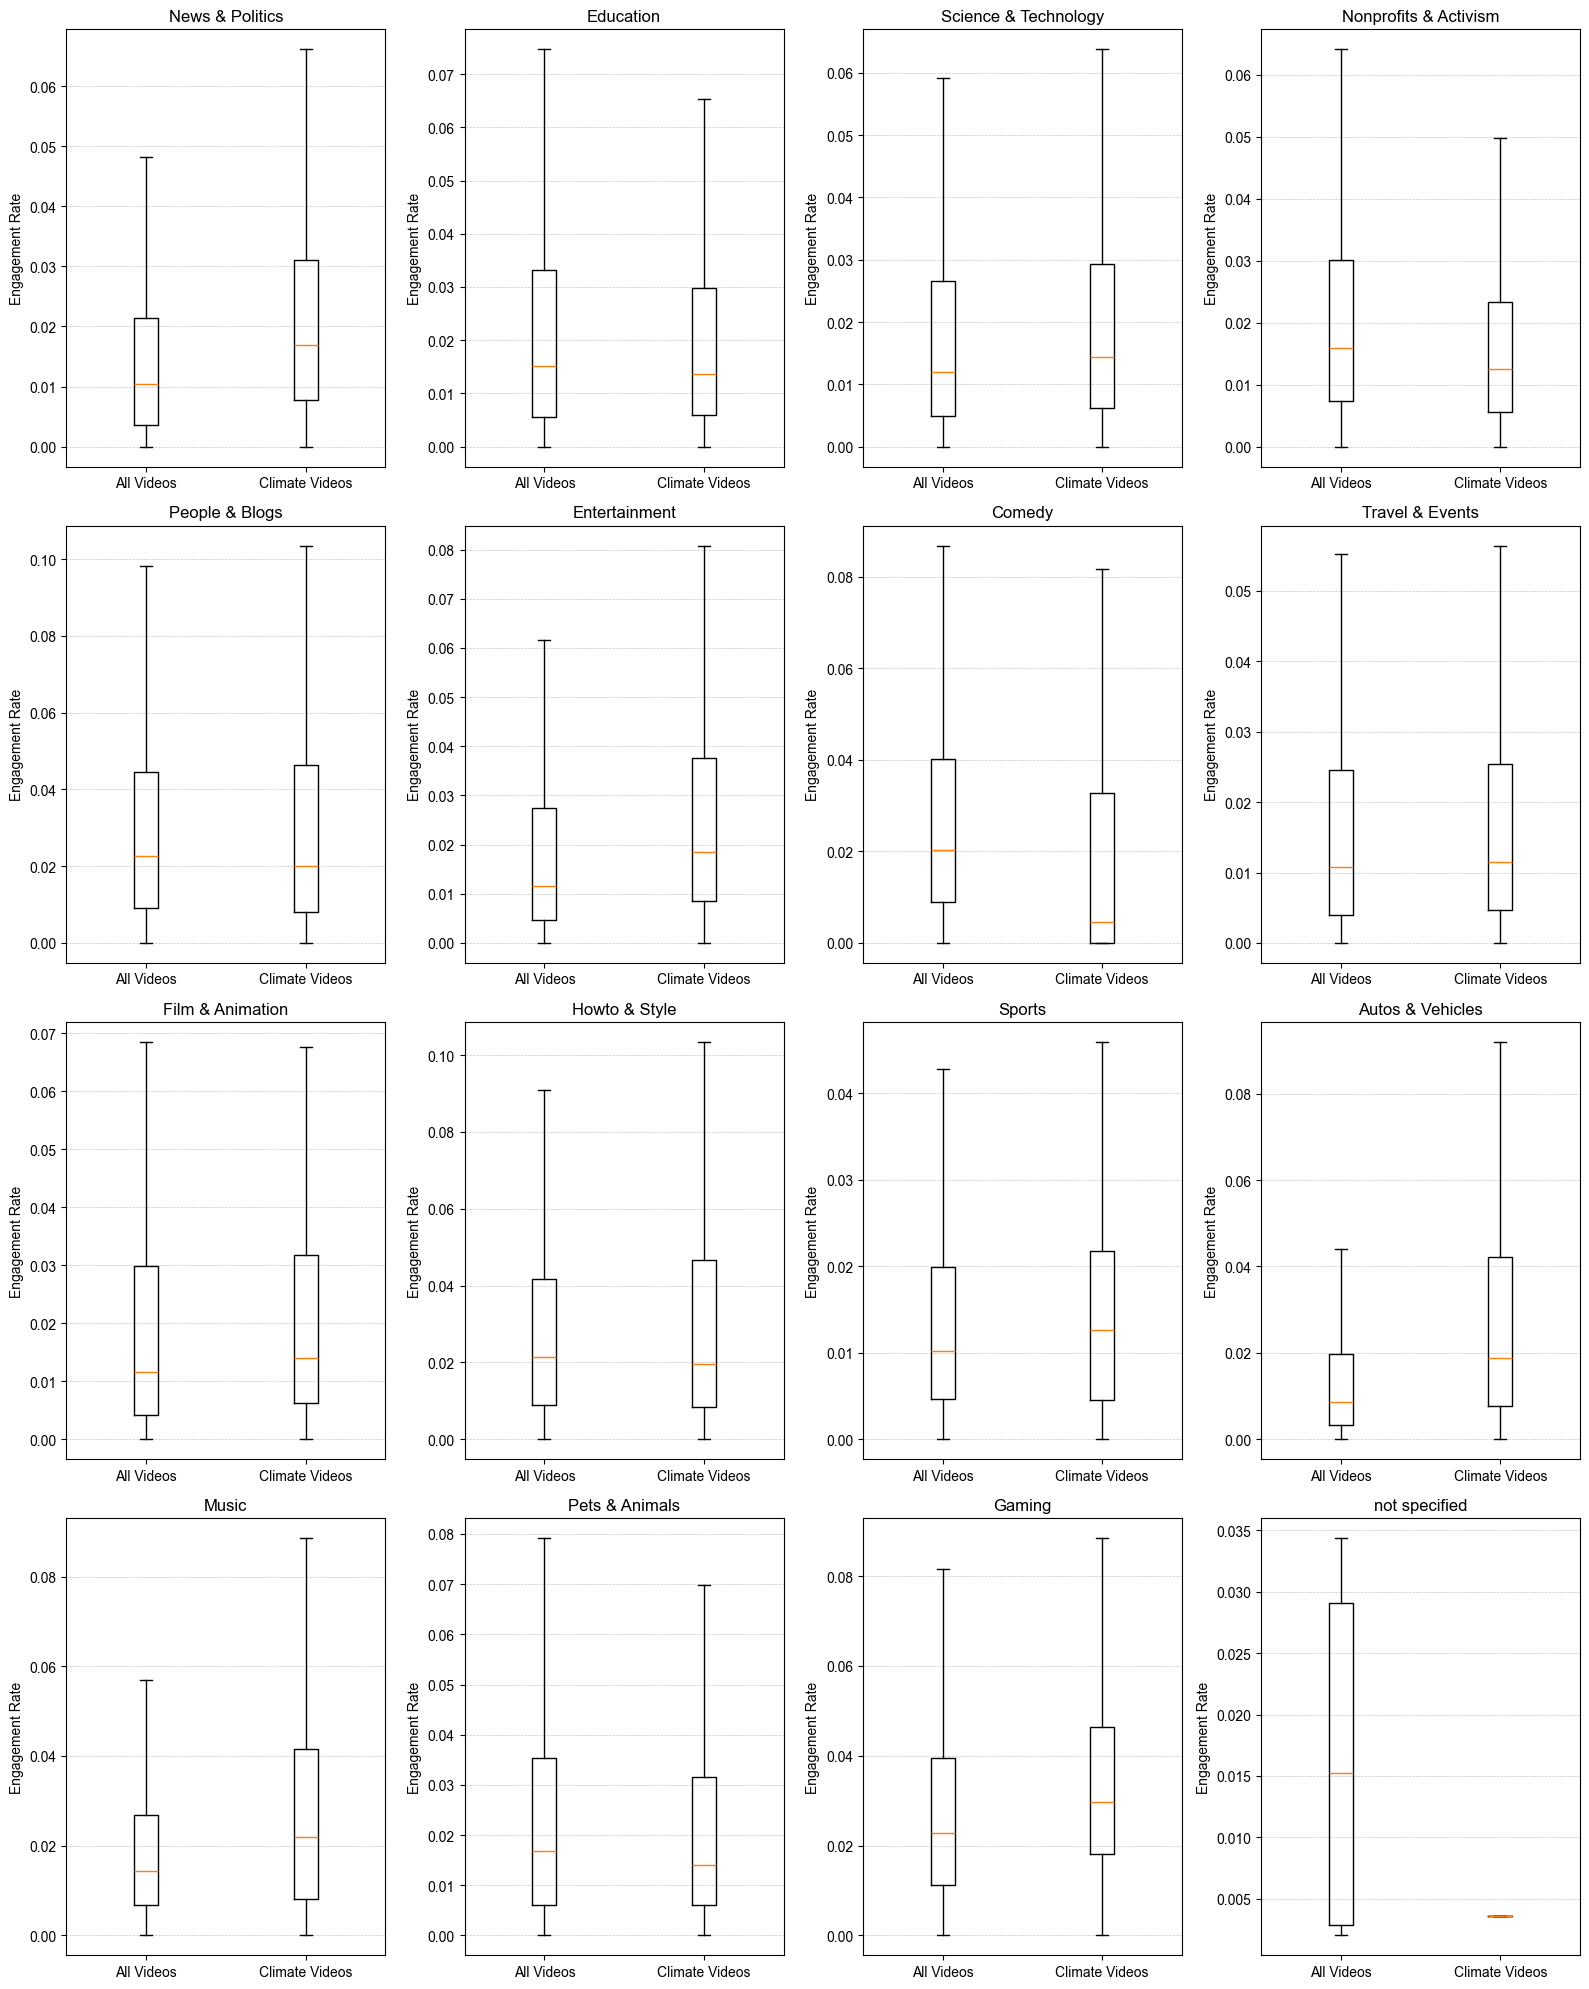

In [ ]:
plt.figure(figsize=(16, 20))  # Adjust the figure size as desired

num_categories = len(categories)
num_columns = num_categories // 4  # Number of columns in the subplot grid
num_rows = num_categories // 4   # Number of rows in the subplot grid

for i, category in enumerate(categories):
    plt.subplot(num_rows, num_columns, i+1)
    
    engagement_rate_all = all_videos_df.query(f"categories == '{category}'")['engagement_rate'].dropna()
    engagement_rate_climate = climate_videos_df.query(f"categories == '{category}'")['engagement_rate'].dropna()
    
    plt.boxplot([engagement_rate_all, engagement_rate_climate], showfliers=False)
    plt.ylabel('Engagement Rate')
    plt.title(category)
    
    plt.grid(axis='y', which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Add x labels
    plt.xticks([1, 2], ['All Videos', 'Climate Videos'])

plt.tight_layout()
plt.show()

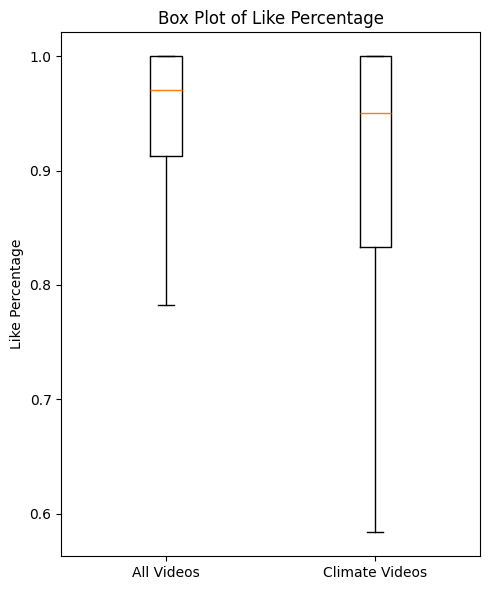

In [ ]:
plt.figure(figsize=(5, 6))
plt.boxplot([all_videos_df['like_percentage'].dropna(), climate_videos_df['like_percentage'].dropna()], showfliers=False)
plt.ylabel('Like Percentage')
plt.title('Box Plot of Like Percentage') 
#plt.grid(axis='y', which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
# Add x labels
plt.xticks([1, 2], ['All Videos', 'Climate Videos'])
plt.tight_layout()
plt.show()

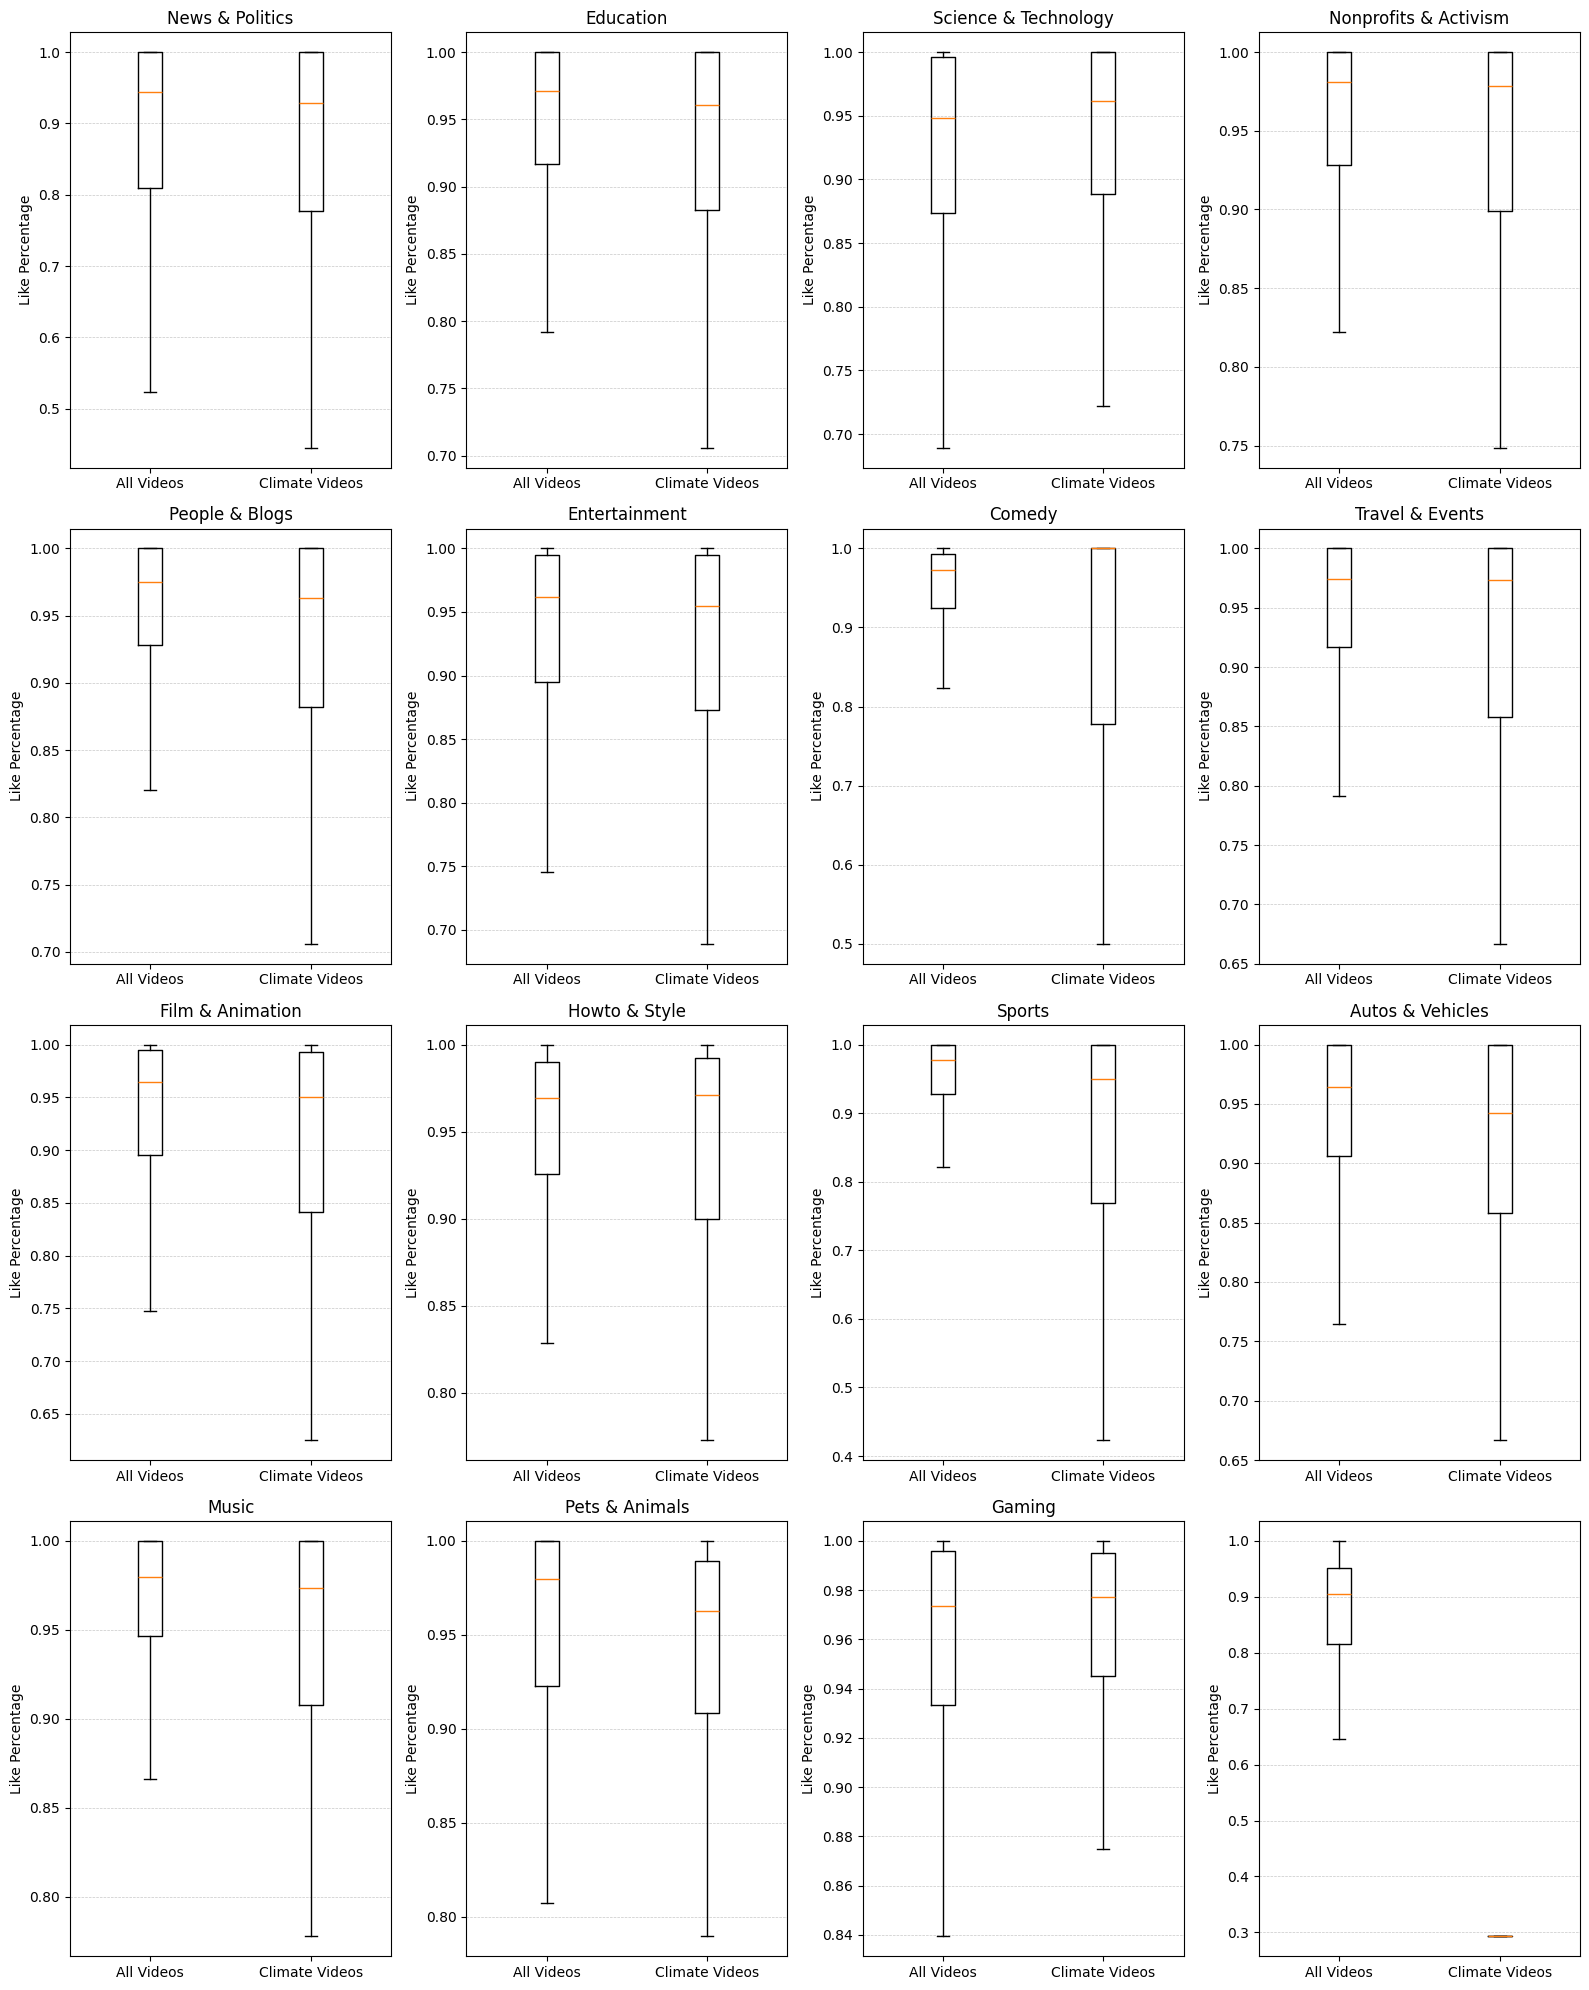

In [ ]:
plt.figure(figsize=(16, 20))  # Adjust the figure size as desired

num_categories = len(categories)
num_columns = num_categories // 4  # Number of columns in the subplot grid
num_rows = num_categories // 4   # Number of rows in the subplot grid

for i, category in enumerate(categories):
    plt.subplot(num_rows, num_columns, i+1)
    
    like_percentage_all = all_videos_df.query(f"categories == '{category}'")['like_percentage'].dropna()
    like_percentage_climate = climate_videos_df.query(f"categories == '{category}'")['like_percentage'].dropna()
    
    plt.boxplot([like_percentage_all, like_percentage_climate], showfliers=False)
    plt.ylabel('Like Percentage')
    plt.title(category)
    
    plt.grid(axis='y', which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Add x labels
    plt.xticks([1, 2], ['All Videos', 'Climate Videos'])

plt.tight_layout()
plt.show()

Climate concerned people growing, but climato skeptical vids ?